In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_parquet('/content/drive/MyDrive/BA820 Project/merged_data1.parquet')
print(df.head())

                 user_id                 name_x           time  rating  \
0  116404531305033742641  Zygintas Krasodomskis  1568240961087     5.0   
1  101806853201406057266            Olga Harbar  1590701094969     3.0   
2  110623621391484838669             Amit Patel  1558575636156     4.0   
3  114893265310260912873         Jerry Cardillo  1535435901765     4.0   
4  106080008682473967828           Jake Moreira  1487952273508     4.0   

                                                text  resp  \
0                     Honestly, best burgers in town  None   
1                                               None  None   
2                                               None  None   
3                                               None  None   
4  This place gave me a good sanwich and a fry bu...  None   

                                 gmap_id                 name_y  \
0  0x89e37a19e56a4565:0xbb2aefc495e8c505              Five Guys   
1  0x89e45acc1861f709:0x9ccc502a907ff195  Price 

In [3]:
df.isnull().sum()

,0
user_id,0
name_x,0
time,0
rating,0
text,391626
resp,756452
gmap_id,0
name_y,0
address,0
latitude,0


In [4]:
df['text'] = df['text'].fillna("N/A")
df['resp'] = df['resp'].fillna("N/A")

In [5]:
df.isnull().sum()

,0
user_id,0
name_x,0
time,0
rating,0
text,0
resp,0
gmap_id,0
name_y,0
address,0
latitude,0


In [6]:
numerical_cols = ['rating', 'latitude', 'longitude', 'avg_rating', 'num_of_reviews']
categorical_cols = ['category']
text_cols = ['text', 'resp']

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_scaled = scaler.fit_transform(df[numerical_cols])

num_df = pd.DataFrame(num_scaled, columns=[f"num_feature_{i}" for i in range(num_scaled.shape[1])])

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
category_encoded = mlb.fit_transform(df[categorical_cols])

# Convert to DataFrame with proper column names
category_df = pd.DataFrame(category_encoded, columns=mlb.classes_)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer_text = TfidfVectorizer(stop_words='english', max_features=50)
vectorizer_resp = TfidfVectorizer(stop_words='english', max_features=50)

text_transformed = vectorizer_text.fit_transform(df['text'])
resp_transformed = vectorizer_resp.fit_transform(df['resp'])

# Convert to DataFrame
text_df = pd.DataFrame(text_transformed.toarray(), columns=[f"text_{col}" for col in vectorizer_text.get_feature_names_out()])
resp_df = pd.DataFrame(resp_transformed.toarray(), columns=[f"resp_{col}" for col in vectorizer_resp.get_feature_names_out()])

In [13]:
from sklearn.cluster import KMeans
import numpy as np

final_df = pd.concat([num_df, category_df, text_df, resp_df], axis=1)
final_df.isnull().sum()

,0
num_feature_0,0
num_feature_1,0
num_feature_2,0
num_feature_3,0
num_feature_4,0
...,...
resp_thank,0
resp_thanks,0
resp_time,0
resp_visit,0


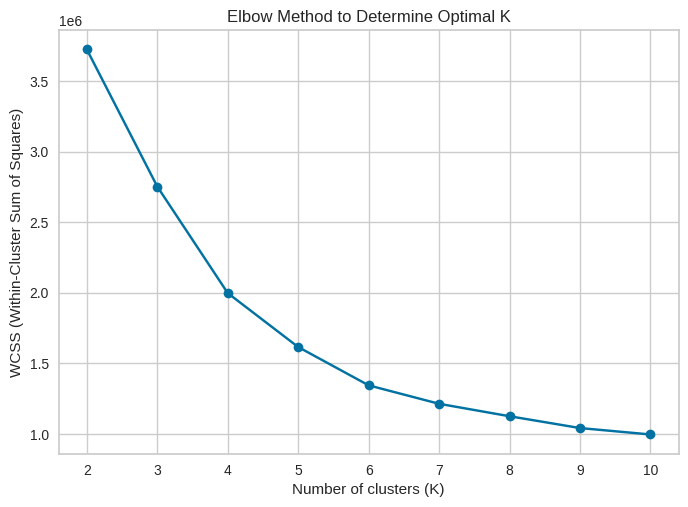

In [16]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

wcss = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(num_df)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method to Determine Optimal K')
plt.show()



There is no clear “sharp elbow,” but K=4 seems to be a reasonable choice, as it is the last point before diminishing returns in WCSS reduction.

In [26]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
num_df['cluster'] = kmeans.fit_predict(num_df)

# Check cluster counts
print(num_df['cluster'].value_counts())

cluster
0    637798
1    191975
3     31643
2        76
Name: count, dtype: int64


**Cluster Distribution:**
* Cluster 0 (Normal Businesses): 637,798 businesses – likely represents the majority of typical businesses.
* Cluster 1 (Moderate Variation): 191,975 businesses – may indicate a slightly different pattern in customer engagement.
* Cluster 3 (Potential Anomalies): 31,643 businesses – possible outliers that deviate from the main group.
* Cluster 2 (Highly Suspicious Group): Only 76 businesses – these businesses might be fraudulent or have manipulated reviews.


##Investigate Anomalous Clusters

In [27]:
suspicious_businesses = num_df[num_df['cluster'] == 2]
print(suspicious_businesses.describe())

       num_feature_0  num_feature_1  num_feature_2  num_feature_3  \
count      76.000000   7.600000e+01   7.600000e+01      76.000000   
mean       -0.048755  -4.580410e+01   1.033187e+02       0.135487   
std         1.098156   7.867904e-14   8.583168e-14       0.552596   
min        -2.891104  -4.580410e+01   1.033187e+02      -1.571443   
25%        -0.267397  -4.580410e+01   1.033187e+02      -0.284472   
50%         0.607172  -4.580410e+01   1.033187e+02       0.230317   
75%         0.607172  -4.580410e+01   1.033187e+02       0.745105   
max         0.607172  -4.580410e+01   1.033187e+02       0.745105   

       num_feature_4  cluster  
count      76.000000     76.0  
mean       -0.485451      2.0  
std         0.035156      0.0  
min        -0.579157      2.0  
25%        -0.485303      2.0  
50%        -0.481101      2.0  
75%        -0.443979      2.0  
max        -0.443979      2.0  


The scaled avg_rating (num_feature_3) reveals a range from -1.57 to 0.74, indicating that some businesses have negative values, suggesting a poor reputation or low trustworthiness, while others have slightly positive but not extreme ratings, possibly due to inflated or manipulated scores. Additionally, the scaled num_of_reviews (num_feature_4) shows a mean of -0.48, with a narrow range from -0.57 to -0.44, indicating that businesses in this cluster generally have very few reviews. This pattern raises red flags, as fraudulent businesses often have artificially generated or minimal engagement, which could point to inactive businesses, manipulated listings, or fake accounts. These insights strongly suggest that businesses in this cluster exhibit unusual or potentially deceptive behavior, warranting further investigation.

##Visualization

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


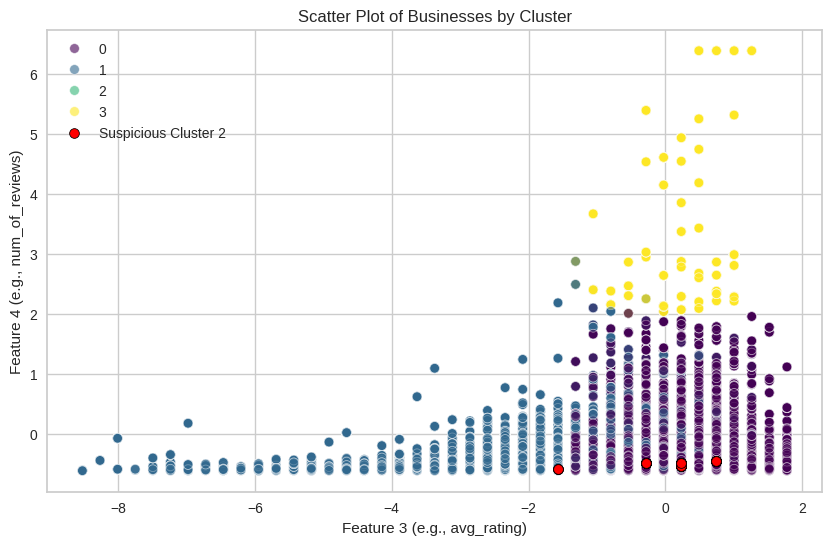

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for all clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=num_df["num_feature_3"],  # Replace with actual feature (e.g., avg_rating)
                y=num_df["num_feature_4"],  # Replace with actual feature (e.g., num_of_reviews)
                hue=final_df["cluster"],
                palette="viridis",
                alpha=0.6)

# Highlight the suspicious Cluster 2 in red
suspicious_businesses = num_df[num_df["cluster"] == 2]
sns.scatterplot(x=suspicious_businesses["num_feature_3"],
                y=suspicious_businesses["num_feature_4"],
                color="red",
                label="Suspicious Cluster 2",
                edgecolor="black")

plt.xlabel("Feature 3 (e.g., avg_rating)")  # Change label based on actual feature
plt.ylabel("Feature 4 (e.g., num_of_reviews)")
plt.title("Scatter Plot of Businesses by Cluster")
plt.legend()
plt.show()